In [2]:
# YIKAI MAO

# quantum search algorithm generator

In [3]:
# reproducibility
%env PYTHONHASHSEED=0

# Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, Aer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from qiskit.transpiler.passes import RemoveBarriers
from qiskit.circuit.library import Diagonal, QFT, GroverOperator, ZGate

print('*'*104)
print("available simulators:")
display(Aer.backends())
print('*'*104)

# other libraries
from tqdm import tqdm #tqdm(iterable)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as trans
from sklearn.metrics import r2_score
import pickle

env: PYTHONHASHSEED=0
********************************************************************************************************
available simulators:


[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

********************************************************************************************************


In [4]:
# utility functions

def run_ideal_simulation(circuit, shots, optimization_level, seed, show_plot, show_counts):
    # assume perfect device with no noise
    # circuit = circuit to simulate, not transpiled
    # shots = how many shots to run
    # optimization_level = passed to the transpiler, min = 0, max = 3
    # seed = random seed for simultaion, can be None
    # show_counts = T/F, plot result or not

    simulator = Aer.get_backend('aer_simulator')
    temp_qc = transpile(circuit, simulator, optimization_level=optimization_level)
    job_temp = simulator.run(temp_qc, shots=shots, seed_simulator=seed)
    temp_results = job_temp.result()
    
    # build simulation result dict
    raw_counts = temp_results.get_counts()
    # print("raw counts:\n", raw_counts)
    num_clbits = circuit.num_clbits
    ideal_result_dict = {}

    # sorting the raw counts, add state zero
    for i in range(pow(2, num_clbits)):
        bin_str = format(i, str('0>' + str(num_clbits) + 'b'))
        if bin_str not in raw_counts:
            ideal_result_dict[bin_str] = 0
        else:
            ideal_result_dict[bin_str] = raw_counts[bin_str]

    if show_plot:
        plot = plot_histogram(raw_counts, title='ideal simulation')
        display(plot)
            
    if show_counts:
        print('sorted counts:')
        print(ideal_result_dict)
    
    return ideal_result_dict, raw_counts

def decomposer(circ, level=1):
    # decompose the circuit to see the basis gates
    # level = how many times to decompose
    
    decomposed_circ = circ
    
    for i in range(level):
        decomposed_circ = decomposed_circ.decompose()
        
    return decomposed_circ

# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def random_bin_str(width, zero=False):
    # return random binary string based on width
    # zero = T/F, T = include 0, F = do not return 0
    # width cannot be 0
    
    if width == 0:
        return None
    
    b = np.random.randint(2, size=width)
    b_str = ''.join(map(str, b.tolist()))
    
    if zero==True:
        return b_str
    
    else:
        while '1' not in b_str:
            b = np.random.randint(2, size=width)
            b_str = ''.join(map(str, b.tolist()))
        
        return b_str

In [5]:
# https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/grover.ipynb

class _oracle:
    # grover oracle class
    def __init__(self, gate, sol):
        self.gate = gate
        self.sol = sol
        
    @property
    def iterations(self):
        return int(np.floor((np.pi/4)*np.sqrt((2**self.gate.num_qubits)/len(self.sol))))

def grover_diffuser(n):
    
    qc = QuantumCircuit(n)
    
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(n):
        qc.h(qubit)
        
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(n):
        qc.x(qubit)
        
    # Do multi-controlled-Z gate
    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)  # multi-controlled-toffoli
    qc.h(n-1)
    
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(n):
        qc.x(qubit)
        
    # Apply transformation |00..0> -> |s>
    for qubit in range(n):
        qc.h(qubit)
        
    # We will return the diffuser as a gate
    diffuser = qc.to_gate()
    diffuser.name = "Diffuser"
    return diffuser

def grover(n, options=[]):
    # n is problem size, NOT necessarily equal to the qubit count of the generated circuit
    # n = number of qubits of the grover oracle, n must >= 2
    # options = [print_solutions]
    # print_solutions = show solutions, optimal iteration
    # optimal iteration will always be 1 here (due to nsolutions = 2**(n-2))
    
    print_solutions = options[0]
    
    grover_circuit = QuantumCircuit(n)
    
    # init
    grover_circuit.h(list(range(n)))
    grover_circuit.barrier(list(range(n)))
    
    # core
    core = QuantumCircuit(n)
    
    if n < 3:
        nsolutions = 1
    else:
        # nsolutions = np.random.randint(1, np.ceil((2**n)/4)) # iteration will be >=1
        nsolutions = 2**(n-2)
    
    diagonal_elements = [-1]*nsolutions + [1]*((2**n) - nsolutions)
    np.random.shuffle(diagonal_elements)
    #print(diagonal_elements) # diagonal matrix elements
    oracle_gate = Diagonal(diagonal_elements)
    
    sol = []
    for idx, e in enumerate(diagonal_elements):
        if e < 1:
            state = "%s" % format(idx, "0%ib" % n)
            sol.append(state)
    
    oracle_gate.name = "Grover Oracle"
    
    grover_oracle = _oracle(oracle_gate, sol)
    
    if print_solutions:
        print("solutions:", grover_oracle.sol)
        print("total:", len(grover_oracle.sol))
        print("optimal iteration:", grover_oracle.iterations)

    core.append(grover_oracle.gate, list(range(n)))
    core.append(grover_diffuser(n), list(range(n)))
    
    for i in range(grover_oracle.iterations):
        grover_circuit.append(core, list(range(n)))
    
    # measure
    grover_circuit.measure_all()
    
    return grover_circuit

In [6]:
# https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/quantum-counting.ipynb

def quantum_counting(n, options=[]):
    # n is problem size, NOT necessarily equal to the qubit count of the generated circuit
    # Grover iteration circuit for oracle with M/N solutions
    # n = number of counting qubits, circuit has n+t qubits and t classical bits
    # options = [print_oracle]
    # print_oracle = T/F
    
    # this locks num_searching equal to num_counting
    # notice num_searching does not need to be equal (see commented code below)
    # it can affect the accuracy of the algorithm
    num_counting = n # t
    num_searching = n # n
    
    # here n = the full qubit amaount of the generated circuit
    # num_counting = int(np.ceil(n/2)) # t
    # num_searching = n-num_counting # n
    
    print_solutions = options[0]
    
    quantum_counting_circuit = QuantumCircuit(num_counting+num_searching, num_counting)
    
    # Initialize all qubits to |+>
    for qubit in range(num_counting+num_searching):
        quantum_counting_circuit.h(qubit)
    
    quantum_counting_oracle = QuantumCircuit(num_counting+num_searching)
    
    nsolutions = np.random.randint(1, 2**num_searching)
    diagonal_elements = [-1]*nsolutions + [1]*((2**num_searching) - nsolutions)
    np.random.shuffle(diagonal_elements)
    oracle_gate = Diagonal(diagonal_elements)
    
    if print_solutions:
        print("counting qubits =", num_counting)
        print("searching qubits =", num_searching)
        print("num_solutions =", nsolutions)
        print(diagonal_elements) # diagonal matrix elements
    
    # Begin controlled Grover iterations
    n_iterations = 1
    for qubit in range(num_counting):
        
        grover_it = GroverOperator(oracle_gate).repeat(n_iterations).to_gate()
        grover_it.label = "Grover^"+str(n_iterations)
        
        cgrit = grover_it.control()
        quantum_counting_oracle.append(cgrit, 
                                       [qubit] + list(range(num_counting, num_searching+num_counting)))
        
        n_iterations *= 2
    
    # controlled Grover iterations oracle
    quantum_counting_circuit.append(quantum_counting_oracle, range(num_counting+num_searching))    
    
    # Do inverse QFT on counting qubits
    qft_dagger = QFT(num_counting, inverse=True).to_gate()
    qft_dagger.label = "QFT†"
    quantum_counting_circuit.append(qft_dagger, range(num_counting))
    
    # Measure counting qubits
    quantum_counting_circuit.measure(range(num_counting), range(num_counting))
    
    return quantum_counting_circuit

def calculate_M(raw_counts, n):
    # For Processing Output of Quantum Counting
    
    # this locks num_searching equal to num_counting
    # notice num_searching does not need to be equal (see commented code below)
    # it can affect the accuracy of the algorithm
    num_counting = n # t
    num_searching = n # n
    
    # here n = the full qubit amaount of the generated circuit
    # num_counting = int(np.ceil(n/2)) # t
    # num_searching = n-num_counting # n
    
    measured_int = int(max(raw_counts, key=raw_counts.get), 2)
    print("Register Output = %i" % measured_int)
    
    # Calculate Theta
    theta = (measured_int/(2**num_counting))*np.pi*2
    print("Theta = %.5f" % theta)
    
    # Calculate No. of Solutions
    N = 2**num_searching
    M = N * (np.sin(theta/2)**2)
    print(f"No. of Solutions = {M:.1f}")
    
    # Calculate Upper Error Bound
    m = num_counting - 1 #Will be less than this (out of scope) 
    err = (np.sqrt(2*M*N) + N/(2**(m+1)))*(2**(-m))
    print("Error < %.2f" % err)

In [7]:
# https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/
#     quantum-walk-search-algorithm.ipynb

def grover_coin(n):
    # n = number of qubits
    # ...the coin is a Grover coin, 
    # which is the diffuser in Grover's algorithm
    
    coin=QuantumCircuit(n)
    coin.h(range(n))
    
    diagonal_elements = [1] + [-1]*((2**n) - 1)
    daigonal_gate = decomposer(Diagonal(diagonal_elements),4).to_gate()
    # print(diagonal_elements) # diagonal matrix elements
    coin.append(daigonal_gate, list(range(n)))
    
    coin.h(range(n))
    coin = coin.to_gate(label="grover_coin")
    
    return coin

def shift_operator(n):
    # n = number of qubits of the coin
    
    shift_operator = QuantumCircuit(n+2**n)
    
    for i in range(0,2**n):
        if i==0:
            shift_operator.x(list(range(2**n,n+2**n)))
        else:
            f_str = '0'+str(n)+'b'
            i_bin = f'{i:{f_str}}'[::-1] # reversed for qiksit endian
            i_old_bin = f'{(i-1):{f_str}}'[::-1] # reversed for qiksit endian
            diff = [j+2**n for j in range(len(i_bin)) if i_bin[j] != i_old_bin[j]]
            # print(diff)
            shift_operator.x(diff)
        shift_operator.mcx(list(range(2**n,n+2**n)), i)
        
    shift_operator = shift_operator.to_gate(label="shift_operator")
    
    return shift_operator

def mark_auxiliary(n):
    # n = number of qubits of the coin
    # Mark auxiliary if the other qubits are non-zero
    
    mark_auxiliary_circuit = QuantumCircuit(2**n+1)
    mark_auxiliary_circuit.x(list(range(2**n+1)))
    mark_auxiliary_circuit.mcx(list(range(2**n)), 2**n)
    mark_auxiliary_circuit.z(2**n)
    mark_auxiliary_circuit.mcx(list(range(2**n)), 2**n)
    mark_auxiliary_circuit.x(list(range(2**n+1)))
    mark_auxiliary_gate = mark_auxiliary_circuit.to_gate(label="mark_aux")
    
    return mark_auxiliary_gate

def quantum_walk_one_step(n):
    # n = number of qubits of the coin
    
    one_step_circuit = QuantumCircuit(n+2**n)
    one_step_circuit.append(grover_coin(n), list(range(2**n,n+2**n)))
    one_step_circuit.append(shift_operator(n), list(range(n+2**n)))

    return one_step_circuit

def quantum_walk_phase_estimation(n, one_step_circuit):
    # n = number of qubits of the coin
    # one step of quantum walk
    
    # construct one step gates
    inv_cont_one_step = one_step_circuit.inverse().control()
    inv_cont_one_step_gate = inv_cont_one_step.to_instruction()
    
    cont_one_step = one_step_circuit.control()
    cont_one_step_gate = cont_one_step.to_instruction()
    
    # phase estimation
    phase_estimation_circuit = QuantumCircuit(2**n+2**n+n+1)
    
    phase_estimation_circuit.h(list(range(2**n)))
    
    for i in range(0,2**n):
        stop = 2**i
        index = [i]
        for k in range(2**n+n):
            index.append(2**n+k)
        for j in range(0,stop):
            phase_estimation_circuit.append(cont_one_step, index)

    # Inverse fourier transform
    inv_qft_gate = QFT(2**n, inverse=True).to_gate(label="inv_QFT")
    phase_estimation_circuit.append(inv_qft_gate, list(range(2**n)))

    # Mark all angles theta that are not 0 with an auxiliary qubit
    index = list(range(2**n))
    index.append(2**n+2**n+2+1-1)
    phase_estimation_circuit.append(mark_auxiliary(n), index)

    # Reverse phase estimation
    qft_gate = QFT(2**n, inverse=False).to_gate(label="QFT")
    phase_estimation_circuit.append(qft_gate, list(range(2**n)))

    for i in range(2**n-1,-1,-1):
        stop = 2**i
        index = [i]
        for k in range(2**n+n):
            index.append(2**n+k)
        for j in range(0,stop):
            phase_estimation_circuit.append(inv_cont_one_step, index)
    
    # phase_estimation_circuit.barrier()
    phase_estimation_circuit.h(list(range(2**n)))

    # Make phase estimation gate
    phase_estimation_gate = phase_estimation_circuit.to_instruction(label="phase estimation")
    
    return phase_estimation_gate

def quantum_walk(n, options=[]):
    # n is problem size, NOT necessarily equal to the qubit count of the generated circuit
    # n = number of qubits of the coin, must >= 2
    # options = [print_oracle]
    # print_oracle = T/F

    print_solutions = options[0]
    
    # full quantum walk search
    theta_q = QuantumRegister(2**n, 'theta')
    node_q = QuantumRegister(2**n, 'node')
    coin_q = QuantumRegister(n, 'coin')
    auxiliary_q = QuantumRegister(1, 'auxiliary')
    creg_c2 = ClassicalRegister(2**n, 'c')
    quantum_walk_circuit = QuantumCircuit(theta_q, node_q, coin_q, auxiliary_q, creg_c2)
    
    # Apply Hadamard gates to the qubits that represent the nodes and the coin
    quantum_walk_circuit.h(list(range(2**n,2**n+2**n+n)))
    # 1/sqrt(sqrt(M/N))
    iterations = 1/np.sqrt((2**(n-2))/(2**n))
    
    phase_estimation_gate = quantum_walk_phase_estimation(n, quantum_walk_one_step(n))
    
    quantum_walk_oracle =  QuantumCircuit(2**n)
    
    # num_sol = 2**(n-2) for simple iteration calculation
    # may still need more iterations for accurate estimation
    sol = []
    for i in range(2**(n-2)): 
        temp = random_bin_str(2**n, False)
        while temp in sol:
            temp = random_bin_str(n, False)
        sol.append(temp)
        
    if print_solutions:
        print("solutions:", sol)
    
    # use X gate to mark the solution
    for b_str in sol:
        
        # if 0, apply X gate
        for qubit in range(len(b_str)):
            if b_str[qubit] == '0':
                quantum_walk_oracle.x(2**n-qubit-1)
        
        # prepare MCX gate
        quantum_walk_oracle.h(2**n-1)
        quantum_walk_oracle.mcx(list(range(2**n-1)), 2**n-1)
        quantum_walk_oracle.h(2**n-1)
        
        # if 0, apply X gate
        for qubit in range(len(b_str)):
            if b_str[qubit] == '0':
                quantum_walk_oracle.x(2**n-qubit-1)
    
    quantum_walk_oracle = quantum_walk_oracle.to_gate(label="oracle")
    
    for i in range(0,int(iterations)):
        quantum_walk_circuit.append(quantum_walk_oracle, list(range(2**n,2**n+2**n)))
        quantum_walk_circuit.append(phase_estimation_gate, list(range(2**n+2**n+n+1)))
    
    for i in range(node_q.size):
        quantum_walk_circuit.measure(node_q[i], creg_c2[i])
    
    return quantum_walk_circuit

solutions: ['0100', '1001', '1110', '1111']
total: 4
optimal iteration: 1


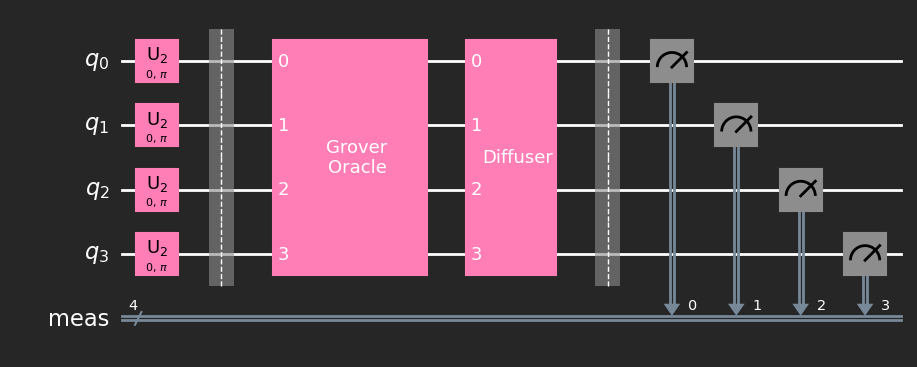

In [10]:
n = 4
print_oracle = True

grover_qc = grover(n, [print_oracle])

decomposer(grover_qc, 1).draw(style="iqp-dark") #iqp, iqp-dark, textbook, bw, clifford

counting qubits = 4
searching qubits = 4
num_solutions = 8
[1, 1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1]


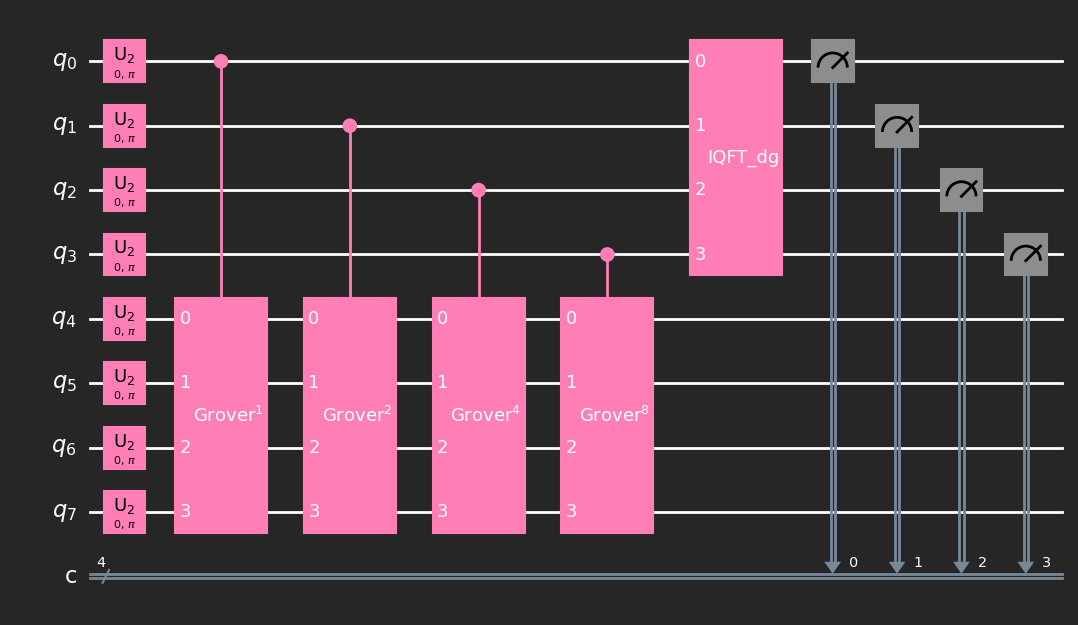

In [15]:
n = 4
print_oracle = True

quantum_counting_qc = quantum_counting(n, [print_oracle])

decomposer(quantum_counting_qc, 1).draw(style="iqp-dark") #iqp, iqp-dark, textbook, bw, clifford

solutions: ['0010']


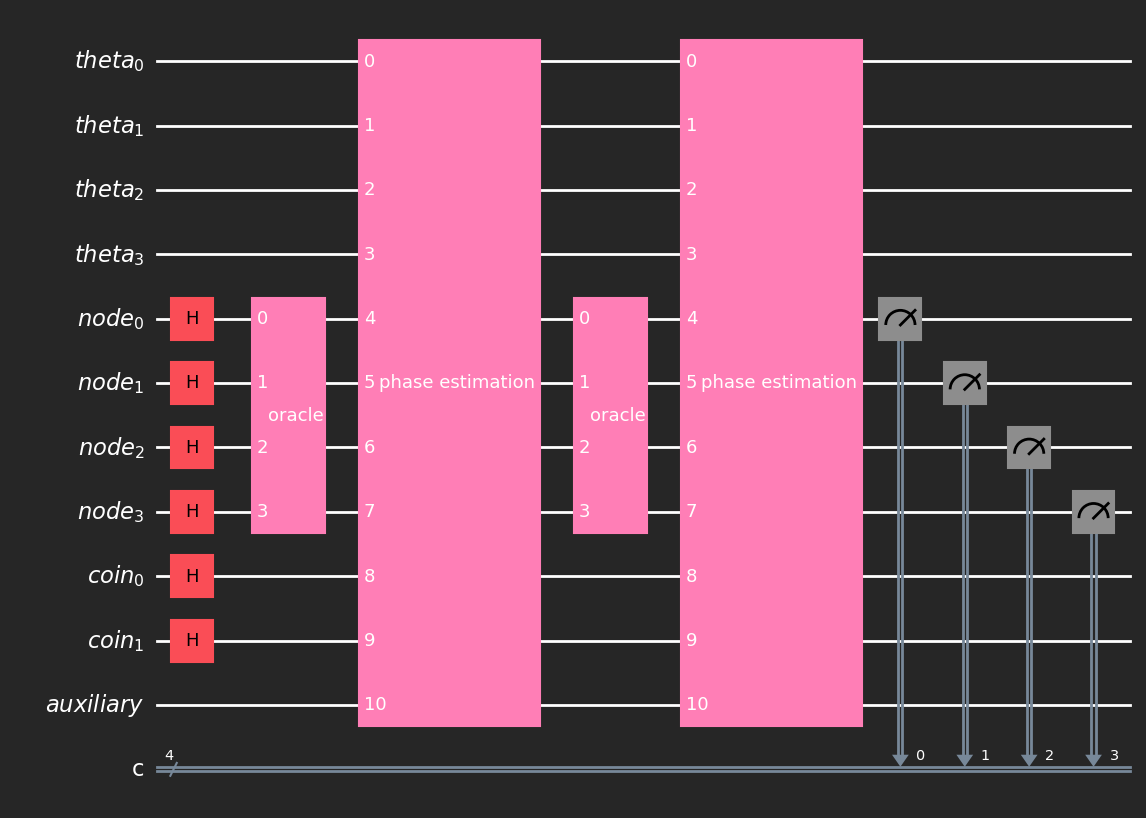

In [12]:
n = 2
print_oracle = True

quantum_walk_qc = quantum_walk(n, [print_oracle])

decomposer(quantum_walk_qc, 0).draw(style="iqp-dark") #iqp, iqp-dark, textbook, bw, clifford

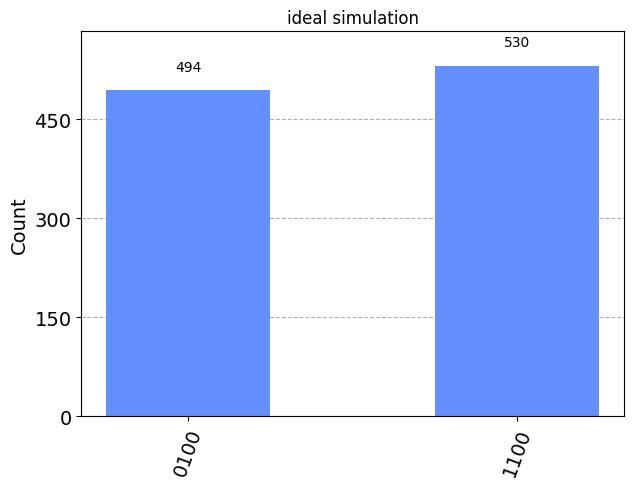

Register Output = 12
Theta = 4.71239
No. of Solutions = 8.0
Error < 2.13
CPU times: user 191 ms, sys: 58.5 ms, total: 250 ms
Wall time: 186 ms


In [16]:
%%time

qc = quantum_counting_qc
shots = 1024
optimization_level = 0
seed = None
show_plot = True
show_counts = False

sorted_counts, raw_counts = run_ideal_simulation(qc, shots, optimization_level, seed, show_plot, show_counts)
calculate_M(raw_counts, n)
# display(sorted_counts['0010'])